In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset"
cstm_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/custom"
resnet_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/resnet"
data_aug_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/augmented"
batch_norm_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/batchnorm"
l2_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/batchnorml2"
batchNorm_drp_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/batchnormdrp"
batchNorm_l2_drp_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/batchnorml2drp"
train_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/train"
val_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/val"
test_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/test"

# Define model and import data

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 10)
        self.conv3 = nn.Conv2d(64, 128, 20)
        self.fc1 = nn.Linear(128*19*19, 120)
        self.fc2 = nn.Linear(120, 3)

    def forward(self, x):
      #print("Start: ",x.shape)
      x = self.conv1(x)
      #print("conv1: ",x.shape)
      x = self.pool(F.relu(x))
      #print("first pool: ",x.shape)
      x= self.conv2(x)
      #print("conv2: ", x.shape)
      x = self.pool(F.relu(x))
      #print("second pool: ",x.shape)
      x= self.conv3(x)
      #print("conv3: ", x.shape)
      x = self.pool(F.relu(x))
      #print("second pool: ",x.shape)
      x = x.view(x.size(0), -1)
      #print("x.view: ", x.shape)
      #x = x.view(-1, 16 * 5 * 5)
      x = self.fc1(x)
      #print("FC1 ", x.shape)
      x = F.relu(x)
      #print("relu fc1: ", x.shape)
      x = self.fc2(x)
      #print("FC2 ", x.shape)
      x = F.relu(x)
      #print("relu fc2: ", x.shape)
      return x

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#                 dilation=1, groups=1, bias=True, padding_mode='zeros')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 10)
        self.conv3 = nn.Conv2d(64, 128, 20)
        self.fc1 = nn.Linear(128*25*25, 120)
        self.fc2 = nn.Linear(120, 3)

    def forward(self, x):
      #print("Start: ",x.shape)
      x = self.conv1(x)
      #print("conv1: ",x.shape)
      x = self.pool(F.relu(x))
      #print("first pool: ",x.shape)
      x= self.conv2(x)
      #print("conv2: ", x.shape)
      x = self.pool(F.relu(x))
      #print("second pool: ",x.shape)
      x= self.conv3(x)
      #print("conv3: ", x.shape)
      x = self.pool(F.relu(x))
      #print("second pool: ",x.shape)
      x = x.view(x.size(0), -1)
      #print("x.view: ", x.shape)
      #x = x.view(-1, 16 * 5 * 5)
      x = self.fc1(x)
      #print("FC1 ", x.shape)
      x = F.relu(x)
      #print("relu fc1: ", x.shape)
      x = self.fc2(x)
      #print("FC2 ", x.shape)
      x = F.relu(x)
      #print("relu fc2: ", x.shape)
      return x


In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

test_dataset = datasets.ImageFolder(
                              root = test_path,
                              transform = image_transforms["train"]
                       )

dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Functions for metrics and visualization

In [ ]:
# Functions to create confusion matrix

def get_confusion_tensor(preds, targets):
  stacked = torch.stack(
      (
          torch.cat(targets, dim=0)
          ,torch.cat(preds, dim=0)
      )
      ,dim=1
  )
  cmt = torch.zeros(3,3, dtype=torch.int64)
  for p in stacked:
      tl, pl = p.tolist()
      cmt[int(tl), int(pl)] = cmt[int(tl), int(pl)] + 1
  return cmt

def plot_confusion_matrix(preds, targets, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  cm = get_confusion_tensor(preds, targets)

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, fontsize='large')
  plt.yticks(tick_marks, classes, fontsize='large')

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", fontsize='large', color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

# Import saved states and infer

## 20 Epoch - Base Model - Experiment 1

In [ ]:
model_path = cstm_chkpt_path+'/20_epoch_custom.pt'
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(20, 20), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
)

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 90 %


tensor([[168,  47,   2],
        [ 29, 583,   0],
        [  1,   7,  73]])


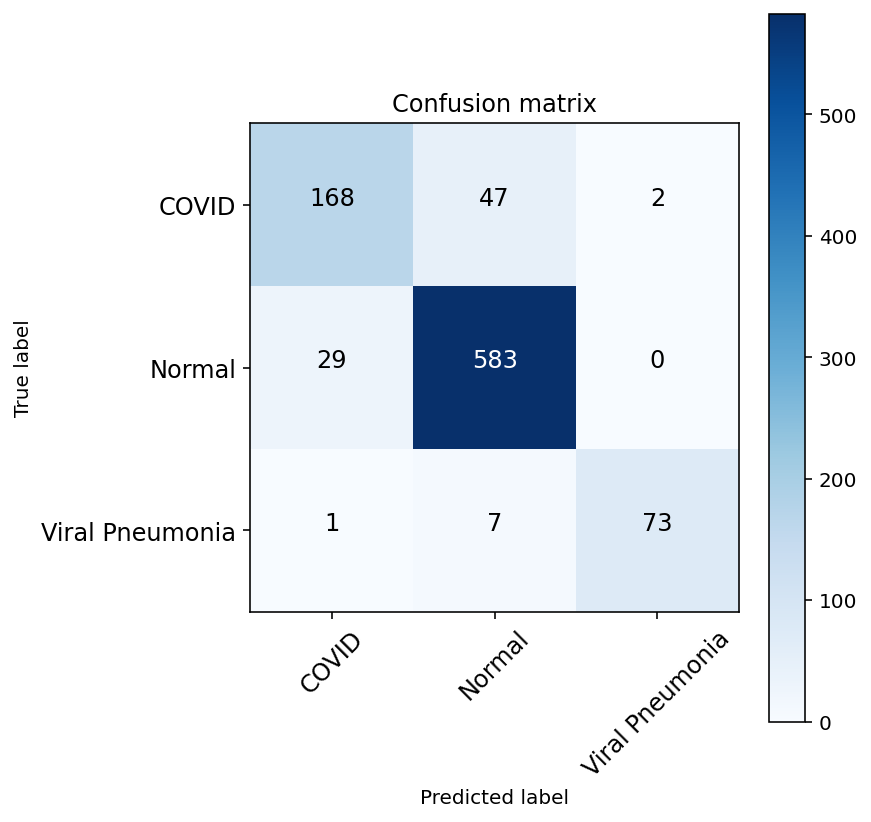

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia'], digits=4))


*Classification Report:
                  precision    recall  f1-score   support

          COVID     0.8485    0.7742    0.8096       217
         Normal     0.9152    0.9526    0.9335       612
Viral Pneumonia     0.9733    0.9012    0.9359        81

       accuracy                         0.9055       910
      macro avg     0.9123    0.8760    0.8930       910
   weighted avg     0.9045    0.9055    0.9042       910




## 40 Epoch data augmentation base model - Experiment 2

In [ ]:
model_path = data_aug_chkpt_path+'/40_epoch_augmented.pt'
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(20, 20), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
)

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 92 %


tensor([[192,  24,   1],
        [ 42, 568,   2],
        [  1,   2,  78]])


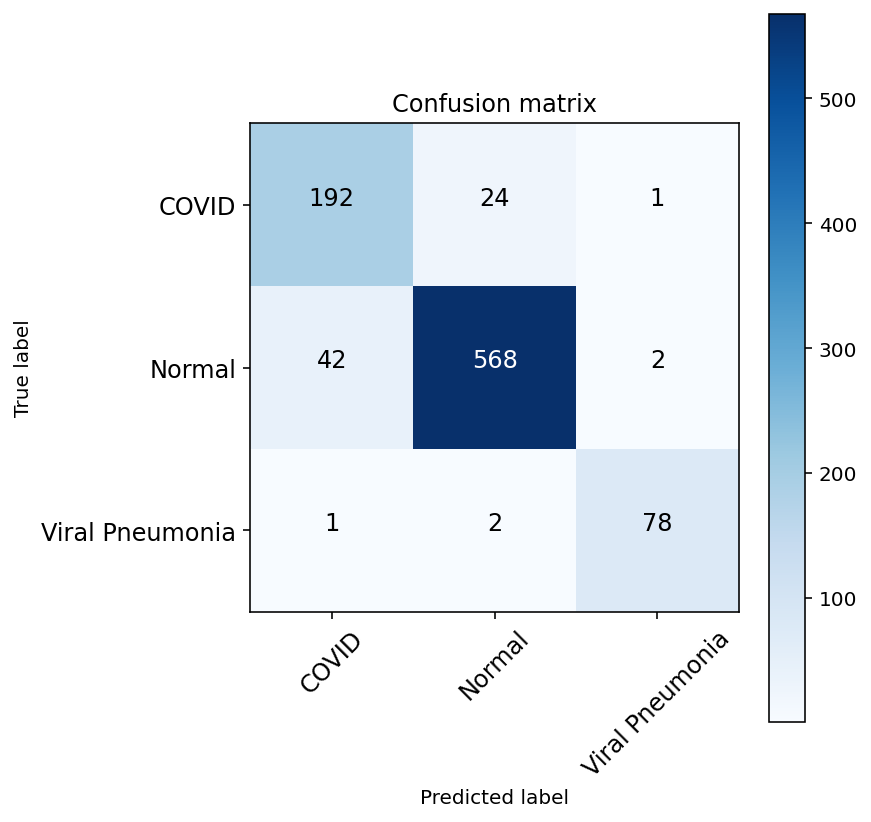

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia'], digits=4))


*Classification Report:
                  precision    recall  f1-score   support

          COVID     0.8170    0.8848    0.8496       217
         Normal     0.9562    0.9281    0.9420       612
Viral Pneumonia     0.9630    0.9630    0.9630        81

       accuracy                         0.9209       910
      macro avg     0.9121    0.9253    0.9182       910
   weighted avg     0.9236    0.9209    0.9218       910



# Batch normal - 25 Epochs - Experiment 3



In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#                 dilation=1, groups=1, bias=True, padding_mode='zeros')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 10)
        self.conv3 = nn.Conv2d(64, 128, 20)
        self.fc1 = nn.Linear(128*25*25, 120)
        self.fc2 = nn.Linear(120, 3)
        self.batchNorm1 = nn.BatchNorm2d(32, momentum=0.04)
        self.batchNorm2 = nn.BatchNorm2d(64, momentum=0.06)
        self.batchNorm3 = nn.BatchNorm2d(128, momentum=0.06)

    def forward(self, x):
      #print("Start: ",x.shape)
      x = self.batchNorm1(self.conv1(x))
      #print("conv1: ",x.shape)
      x = self.pool(F.relu(x))
      #print("first pool: ",x.shape)
      x= self.batchNorm2(self.conv2(x))
      #print("conv2: ", x.shape)
      x = self.pool(F.relu(x))
      #print("second pool: ",x.shape)
      x= self.batchNorm3(self.conv3(x))
      #print("conv3: ", x.shape)
      x = self.pool(F.relu(x))
      #print("second pool: ",x.shape)
      x = x.view(x.size(0), -1)
      #print("x.view: ", x.shape)
      #x = x.view(-1, 16 * 5 * 5)
      x = self.fc1(x)
      #print("FC1 ", x.shape)
      x = F.relu(x)
      #print("relu fc1: ", x.shape)
      x = self.fc2(x)
      #print("FC2 ", x.shape)
      x = F.relu(x)
      #print("relu fc2: ", x.shape)
      return x

In [ ]:
model_path = batch_norm_chkpt_path+'/25_batchNorm.pt'
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(20, 20), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
  (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.04, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
)

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 95 %


tensor([[199,  16,   2],
        [ 16, 595,   1],
        [  0,   6,  75]])


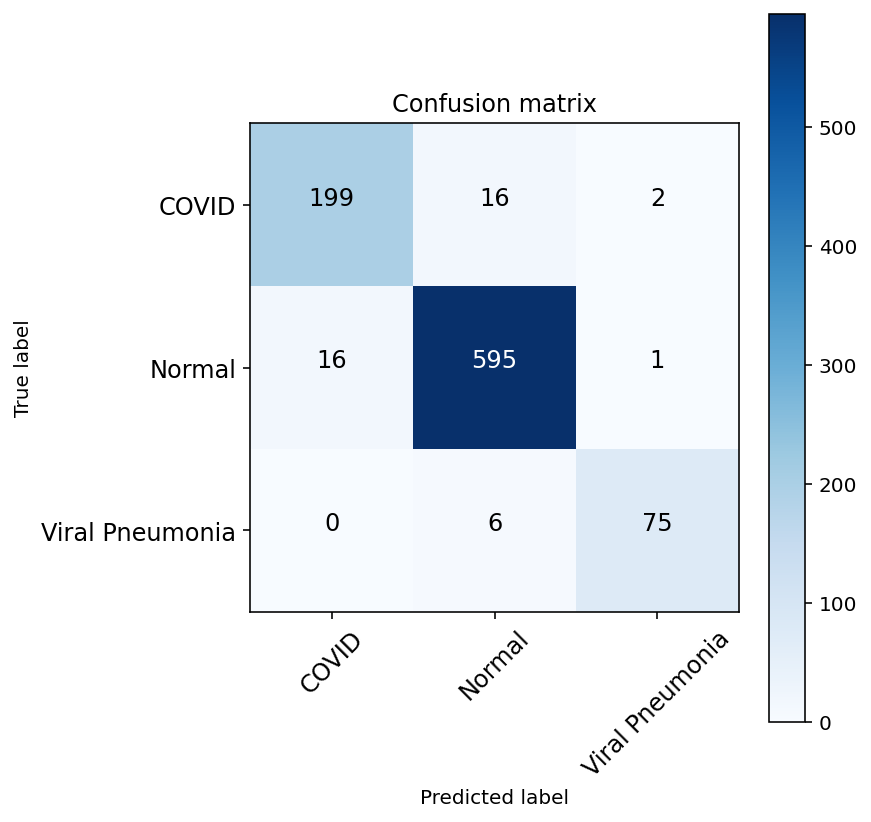

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia'], digits=4))


*Classification Report:
                  precision    recall  f1-score   support

          COVID     0.9256    0.9171    0.9213       217
         Normal     0.9643    0.9722    0.9683       612
Viral Pneumonia     0.9615    0.9259    0.9434        81

       accuracy                         0.9549       910
      macro avg     0.9505    0.9384    0.9443       910
   weighted avg     0.9549    0.9549    0.9549       910



# BatchNormDatAugL2 - 30 Epochs - Experiment 4

In [ ]:
model_path = l2_chkpt_path+'/30_batchNorml2.pt'
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(20, 20), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
  (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.04, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
)

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 95 %


tensor([[197,  18,   2],
        [ 13, 594,   5],
        [  0,   4,  77]])


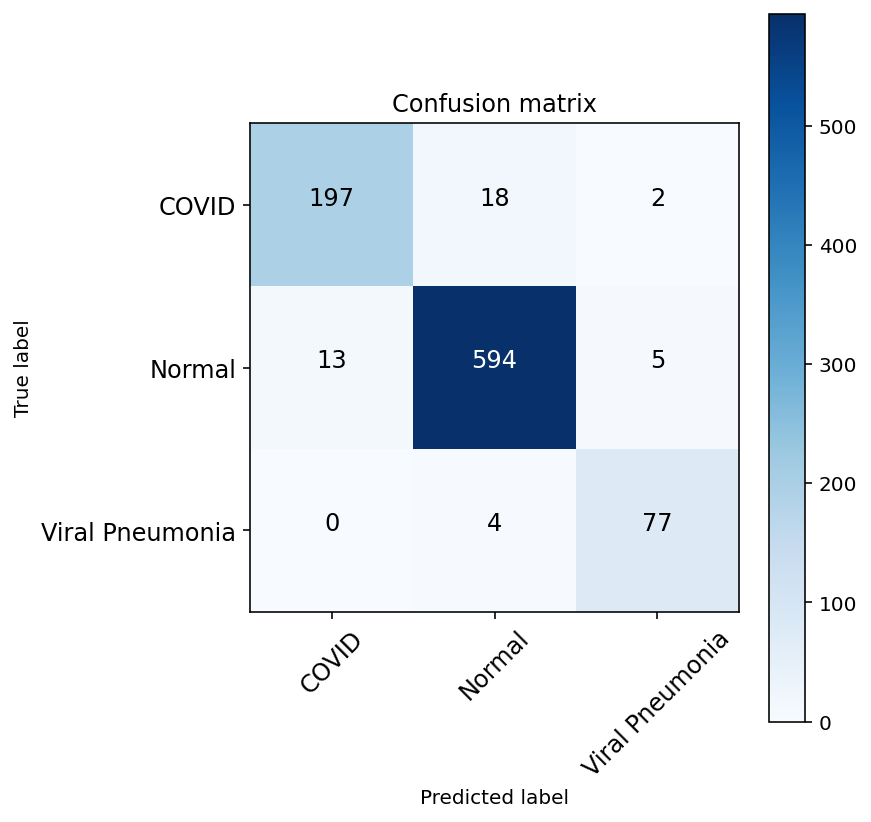

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia'], digits=4))


*Classification Report:
                  precision    recall  f1-score   support

          COVID     0.9381    0.9078    0.9227       217
         Normal     0.9643    0.9706    0.9674       612
Viral Pneumonia     0.9167    0.9506    0.9333        81

       accuracy                         0.9538       910
      macro avg     0.9397    0.9430    0.9412       910
   weighted avg     0.9538    0.9538    0.9537       910



# BatchNorm Data Aug Drop Out - 30 Epochs - Experiment 5

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#                 dilation=1, groups=1, bias=True, padding_mode='zeros')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 10)
        self.conv3 = nn.Conv2d(64, 128, 20)
        self.fc1 = nn.Linear(128*25*25, 120)
        self.fc2 = nn.Linear(120, 3)
        self.batchNorm1 = nn.BatchNorm2d(32, momentum=0.04)
        self.batchNorm2 = nn.BatchNorm2d(64, momentum=0.06)
        self.batchNorm3 = nn.BatchNorm2d(128, momentum=0.06)
        self.dropout1 = torch.nn.Dropout(p=0.08)
        self.dropout2 = torch.nn.Dropout(p=0.10)

    def forward(self, x):
      #print("Start: ",x.shape)
      x = self.batchNorm1(self.conv1(x))
      #print("conv1: ",x.shape)
      x = self.pool(F.relu(x))
      #print("first pool: ",x.shape)
      x= self.batchNorm2(self.conv2(x))
      #print("conv2: ", x.shape)
      x = self.dropout1(self.pool(F.relu(x)))
      #print("second pool: ",x.shape)
      x= self.batchNorm3(self.conv3(x))
      #print("conv3: ", x.shape)
      x = self.dropout2(self.pool(F.relu(x)))
      #print("second pool: ",x.shape)
      x = x.view(x.size(0), -1)
      #print("x.view: ", x.shape)
      #x = x.view(-1, 16 * 5 * 5)
      x = self.fc1(x)
      #print("FC1 ", x.shape)
      x = F.relu(x)
      #print("relu fc1: ", x.shape)
      x = self.fc2(x)
      #print("FC2 ", x.shape)
      x = F.relu(x)
      #print("relu fc2: ", x.shape)
      return x

In [ ]:
model_path = batchNorm_drp_chkpt_path+'/30_batchNorm.pt'
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(20, 20), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
  (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.04, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.08, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 94 %


tensor([[203,  12,   2],
        [ 23, 588,   1],
        [  0,   8,  73]])


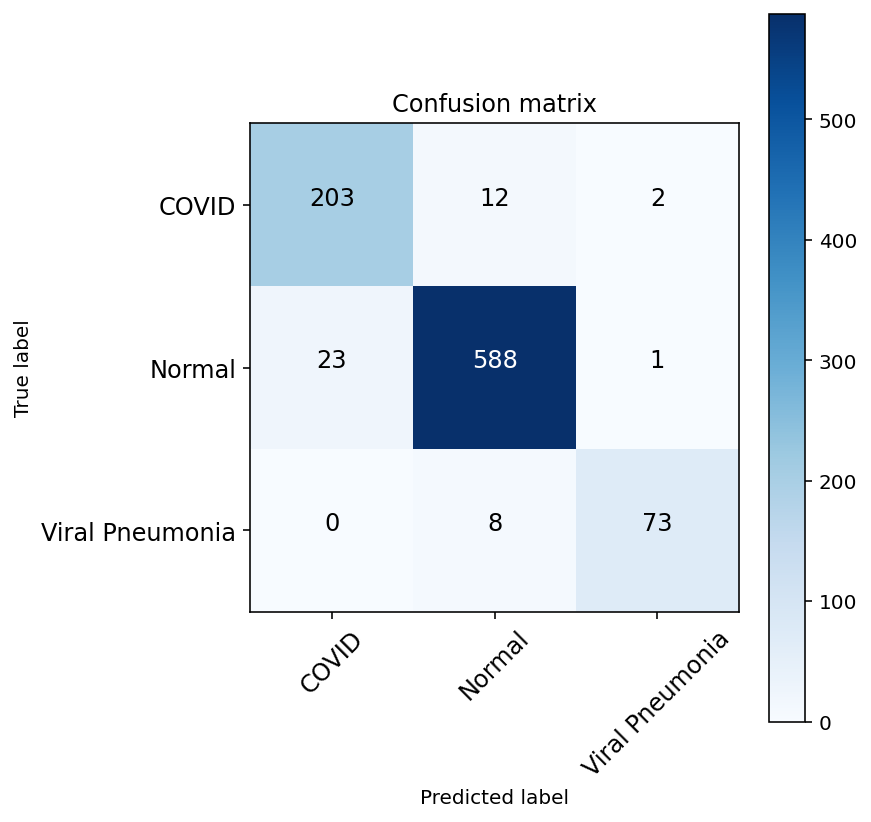

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia'], digits=4))


*Classification Report:
                  precision    recall  f1-score   support

          COVID     0.8982    0.9355    0.9165       217
         Normal     0.9671    0.9608    0.9639       612
Viral Pneumonia     0.9605    0.9012    0.9299        81

       accuracy                         0.9495       910
      macro avg     0.9420    0.9325    0.9368       910
   weighted avg     0.9501    0.9495    0.9496       910



# ResNet

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

test_dataset = datasets.ImageFolder(
                              root = test_path,
                              transform = image_transforms["train"]
                       )

dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# 20 Epochs

In [ ]:
model_path = resnet_chkpt_path+'/20_epoch_resnet.pt'
net = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3)
net.fc = net.fc.cuda() 
net.load_state_dict(torch.load(model_path))
net.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 98 %


tensor([[216,   1,   0],
        [  4, 605,   3],
        [  0,   3,  78]])


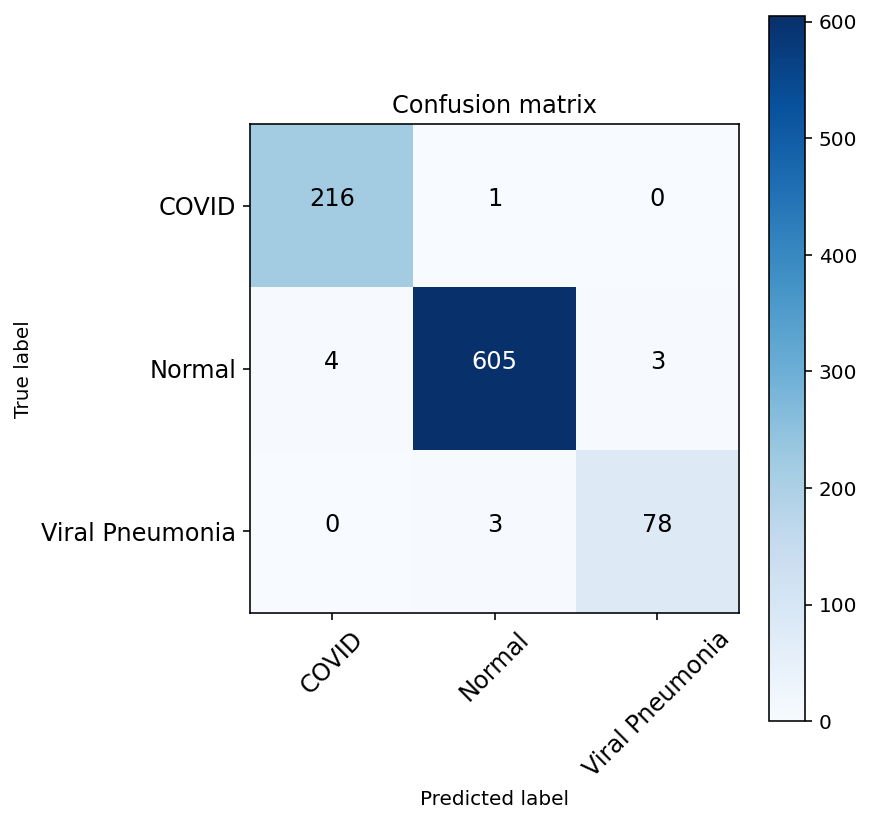

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia'], digits=4))



*Classification Report:
                  precision    recall  f1-score   support

          COVID     0.9818    0.9954    0.9886       217
         Normal     0.9934    0.9886    0.9910       612
Viral Pneumonia     0.9630    0.9630    0.9630        81

       accuracy                         0.9879       910
      macro avg     0.9794    0.9823    0.9808       910
   weighted avg     0.9880    0.9879    0.9879       910

